## Exploration of Various ML Models & Techniques for Predictive Modelling of Mortality & ICU Stay (24H)

Attempt to model impact of selected RISK FACTORS on "risk" outcomes: 'ICUAdmgt24h', 'thirtydaymortality', 'Mortality'
- Create a NEW target variable 'ICUMortalityrisk_ind' to model either 24H ICU or 30-day mortality risk
- DROP 'Mortality' variable

In [1]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Import dataset & generate combined  'ICUAdmgt24h', 'thirtydaymortality' variable 
data = pd.read_csv('../data/CARES_data_predictionv1.csv')
# data = data.drop('Mortality', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69667 entries, 0 to 69666
Data columns (total 16 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GENDER                             69667 non-null  object 
 1   Anemia category                    69667 non-null  object 
 2   Preoptransfusionwithin30days       69667 non-null  float64
 3   Intraop                            69667 non-null  float64
 4   Transfusionintraandpostop          69667 non-null  float64
 5   AnaestypeCategory                  69667 non-null  object 
 6   PriorityCategory                   69667 non-null  object 
 7   TransfusionIntraandpostopCategory  69667 non-null  object 
 8   AGEcategory                        69667 non-null  object 
 9   SurgRiskCategory                   69667 non-null  object 
 10  GradeofKidneyCategory              69667 non-null  object 
 11  RDW15.7                            69667 non-null  obj

In [3]:
data['ICUAdmgt24h'].value_counts(normalize=True)

ICUAdmgt24h
0    0.98322
1    0.01678
Name: proportion, dtype: float64

In [5]:
data['thirtydaymortality'].value_counts(normalize=True)

thirtydaymortality
False    0.992479
True     0.007521
Name: proportion, dtype: float64

In [6]:
data['Mortality'].value_counts(normalize=True)

Mortality
No death    0.92335
Yes         0.07665
Name: proportion, dtype: float64

### Create "Combined" Surgery Risk Indicator
- Either ICU Admission (24H) OR Thirty-Day Mortality
- *Can consider combining all 3 target variables including 'Mortality after surgery'*
- Option (1) was applied!

In [5]:
# create new variable ('ICUMortalityrisk_ind')
data['ICUMortalityrisk_ind'] = ((data['ICUAdmgt24h'] == 1) | (data['thirtydaymortality'] == True) | (data['Mortality'] == 'Yes')).astype(int)
data['ICUMortalityrisk_ind'].value_counts(normalize=True)

ICUMortalityrisk_ind
0    0.913101
1    0.086899
Name: proportion, dtype: float64

In [6]:
# drop other target variables
# data = data.drop(['ICUAdmgt24h', 'thirtydaymortality', 'Mortality'], axis=1)

## Severe Class Imbalance - Review possible Approaches
**Medium Article:** https://medium.com/@narenderbeniwal1234/how-to-deal-with-imbalanced-data-9b7b0bd2f44f
- Balance classes by re-sampling with SMOTE (Not reccommended as class imbalance is 1:50)
- Adjust class weights to give a higher penalty for mis-classifying the minority class
- Use Tree-based Ensemble models (less sensitive to class imbalance)
- Adjust Evaluation Metrics(Precision, Recall:Impt, F1-score, ROCAUC curve, precision recall curve, precision-recall trade-off curve)
- Optimize classification threshold (eg. 0.3 for positive class bias etc.)

In [7]:
# Define categorical, numeric & target columns
# Define the target columns
# target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'ICUMortalityrisk_ind']
target_var = 'ICUAdmgt24h'
target_cols = ['ICUAdmgt24h', 'thirtydaymortality', 'Mortality', 'ICUMortalityrisk_ind']

# Select categorical columns and exclude target columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns.to_list()
cat_cols = [col for col in cat_cols if col not in target_cols]

# Select numerical columns and exclude target columns
num_cols = data.select_dtypes(include=['number']).columns.tolist()
num_cols = [col for col in num_cols if col not in target_cols]

In [8]:
cat_cols

['GENDER',
 'Anemia category',
 'AnaestypeCategory',
 'PriorityCategory',
 'TransfusionIntraandpostopCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned']

In [9]:
num_cols

['Preoptransfusionwithin30days', 'Intraop', 'Transfusionintraandpostop']

### Parameters for Predictive Modelling Framework
- Test models which are more suited for (1) Categorical Variables & (2) Class Imbalance
1. Logistic Regression (with oversampling)
2. Random Forest Ensemble ****Balance by adding class weights***
3. Gradient Boosting
4. XGBoost (optimized?) - Should give the best results
- **Hyperparameter tuning:** All normal hyperparameters, classification threshold*
- **Evaluation:** Precision, Recall:Impt, F1-score, ROCAUC curve, precision recall curve, precision-recall trade-off curve (for threshold selection)

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



Training Logistic Regression...
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensi

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Validation Metrics for Logistic Regression:
Precision: 0.2592
Recall: 0.7297
F1-Score: 0.3825
ROC AUC: 0.8413
PR AUC: 0.3793


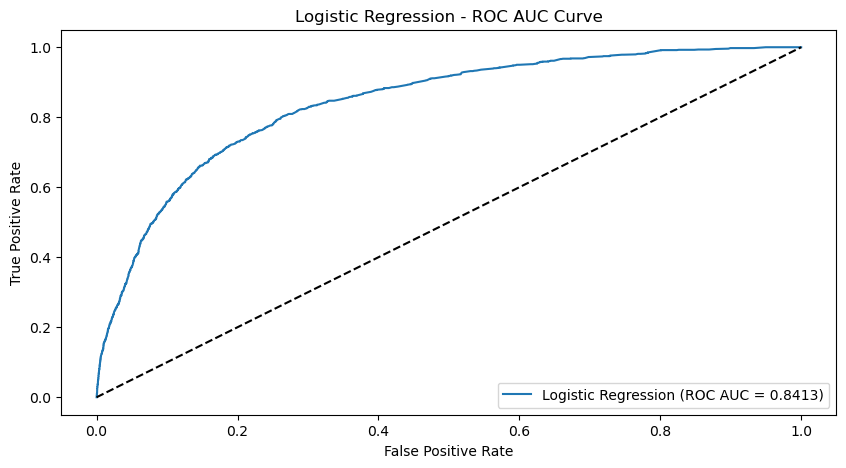

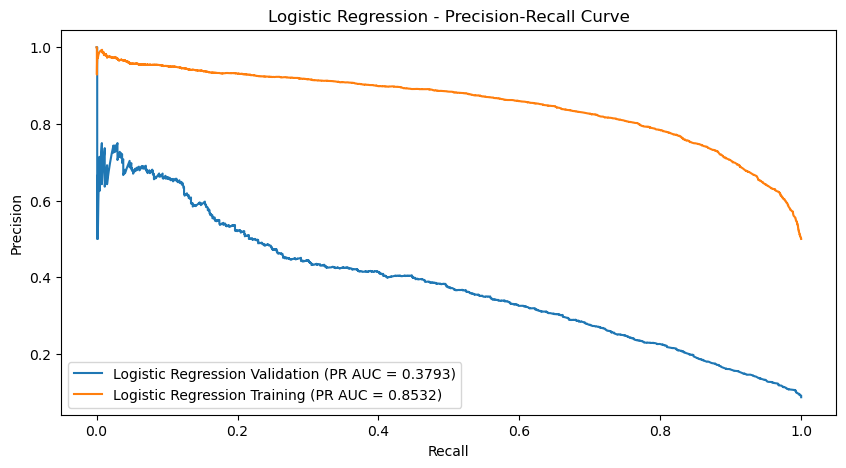


------------------------------------------------------------


Training Random Forest...
Validation Metrics for Random Forest:
Precision: 0.2861
Recall: 0.3747
F1-Score: 0.3244
ROC AUC: 0.7636
PR AUC: 0.2495


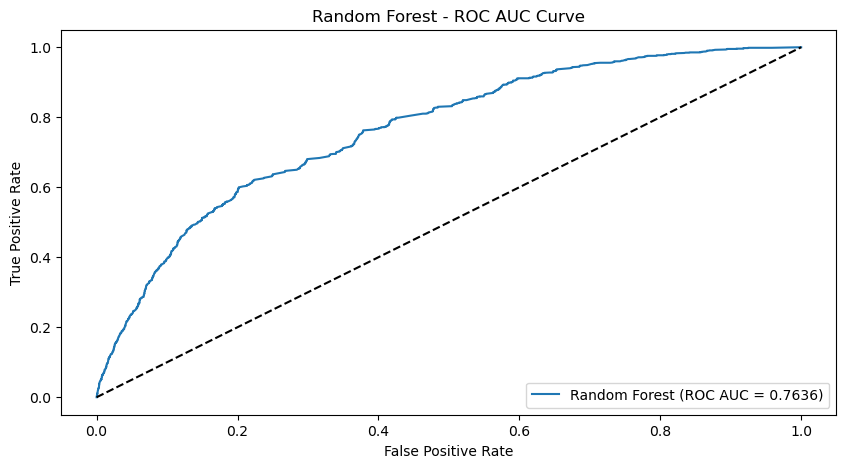

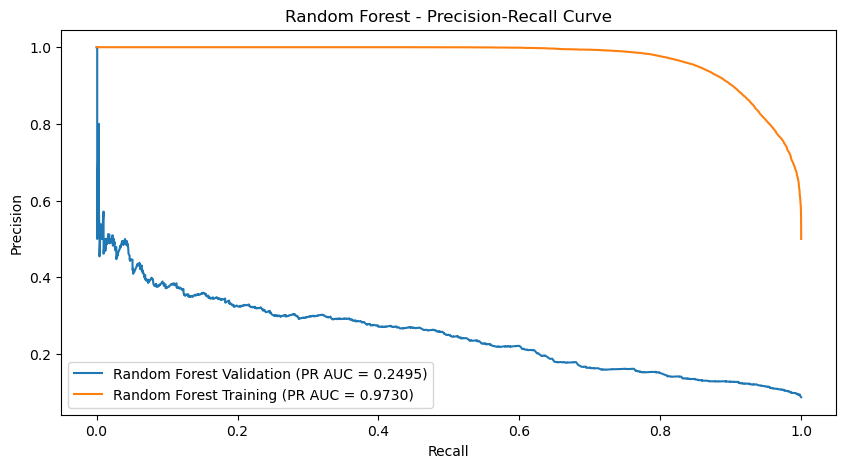


------------------------------------------------------------


Training Gradient Boosting...
Validation Metrics for Gradient Boosting:
Precision: 0.3196
Recall: 0.4536
F1-Score: 0.3750
ROC AUC: 0.8088
PR AUC: 0.3130


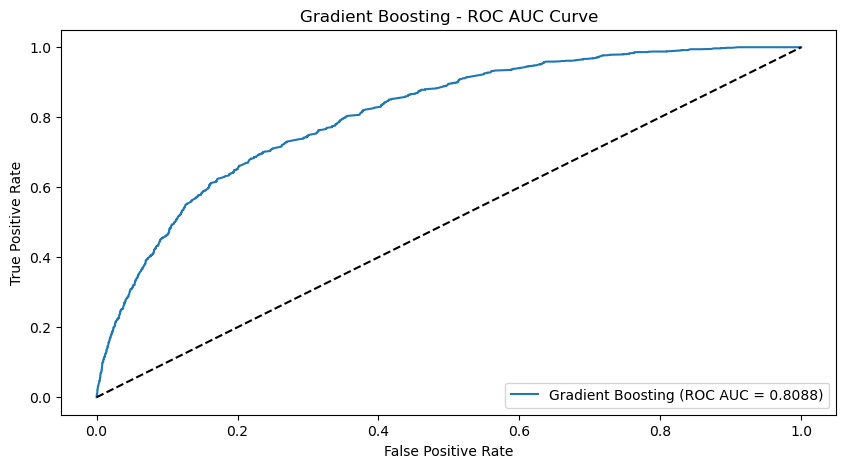

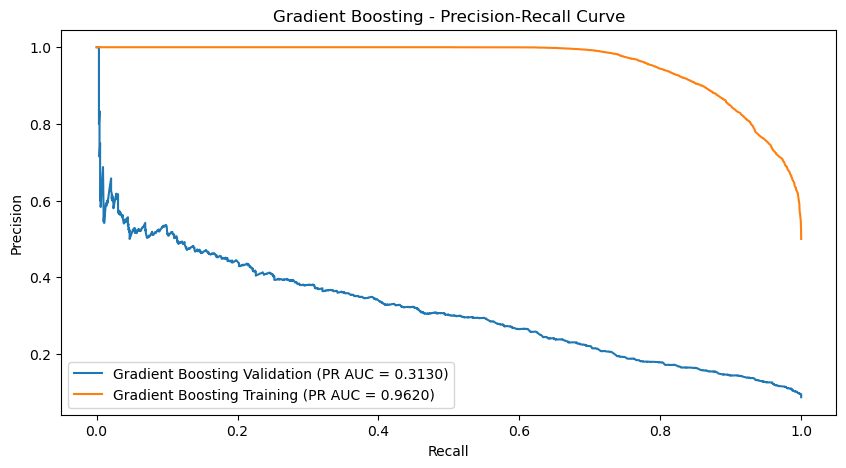


------------------------------------------------------------


Training XGBoost...


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/

In [ ]:
def run_models(data, cat_cols, num_cols, target, threshold=0.5):
    # Split the data into train, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    X_train = train_data[cat_cols + num_cols]
    y_train = train_data[target]
    X_val = val_data[cat_cols + num_cols]
    y_val = val_data[target]
    X_test = test_data[cat_cols + num_cols]
    y_test = test_data[target]

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])

    # Preprocess the training, validation, and test data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

    # Models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }

    # Hyperparameter grids for RandomizedSearchCV
    param_grids = {
        'Logistic Regression': {'C': np.logspace(-3, 3, 10)},
        'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
        'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 7]},
        'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 7]}
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Hyperparameter tuning
        search = RandomizedSearchCV(model, param_grids[model_name], n_iter=10, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
        search.fit(X_train_smote, y_train_smote)

        best_model = search.best_estimator_

        # Predict probabilities
        y_val_pred_prob = best_model.predict_proba(X_val_preprocessed)[:, 1]
        y_test_pred_prob = best_model.predict_proba(X_test_preprocessed)[:, 1]

        # Apply threshold
        y_val_pred = (y_val_pred_prob >= threshold).astype(int)
        y_test_pred = (y_test_pred_prob >= threshold).astype(int)

        # Evaluate metrics
        print(f"Validation Metrics for {model_name}:")
        print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
        print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
        print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_val, y_val_pred_prob):.4f}")
        
        precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob)
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")

        # Plot ROC AUC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, label=f'{model_name} (ROC AUC = {roc_auc_score(y_val, y_val_pred_prob):.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC AUC Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Precision-Recall curve
        plt.figure(figsize=(10, 5))
        plt.plot(recall, precision, label=f'{model_name} Validation (PR AUC = {pr_auc:.4f})')
        train_precision, train_recall, _ = precision_recall_curve(y_train_smote, best_model.predict_proba(X_train_smote)[:, 1])
        train_pr_auc = auc(train_recall, train_precision)
        plt.plot(train_recall, train_precision, label=f'{model_name} Training (PR AUC = {train_pr_auc:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name} - Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

        print("\n" + "-"*60 + "\n")

# Example usage:
run_models(data, cat_cols, num_cols, 'ICUMortalityrisk_ind', threshold=0.5)

### Limitations to Oversampling
- Tackling class imbalance through over-sampling might lead to overfitting as synthetic records are used to balance the minority class. Model might not be able to generalize well to real-world use cases. 
- As seen in the Precision-Recall curves above, we can conclude that oversampling the training data using SMOTE causes overfitting and the resulting models unable to generalise well to the test set. 
- Solution: 
1. Balance class-weights instead. Intuition: Assigning a higher weight to the minority class (positive cases) so that the model pays more attention to it during training.
2. Adjust decision threshold for positive class prediction to give a better "precision-recall balance".


Training Logistic Regression...


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Validation Metrics for Logistic Regression:
Precision: 0.2626
Recall: 0.7214
F1-Score: 0.3851
ROC AUC: 0.8418
PR AUC: 0.3811


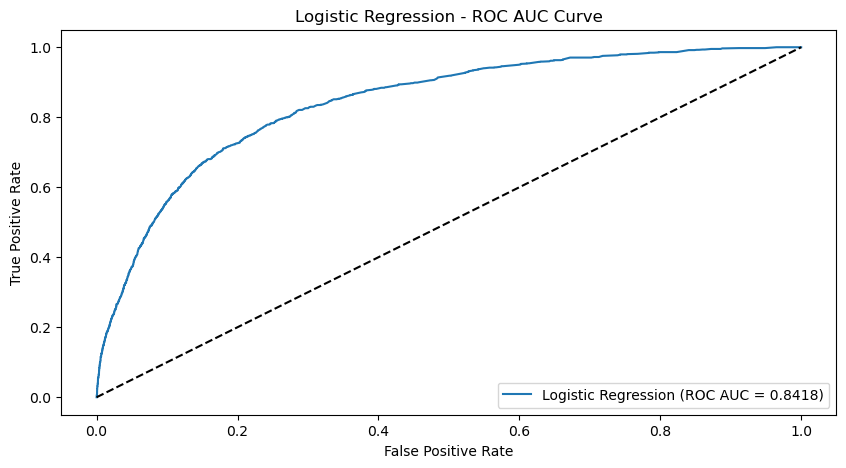

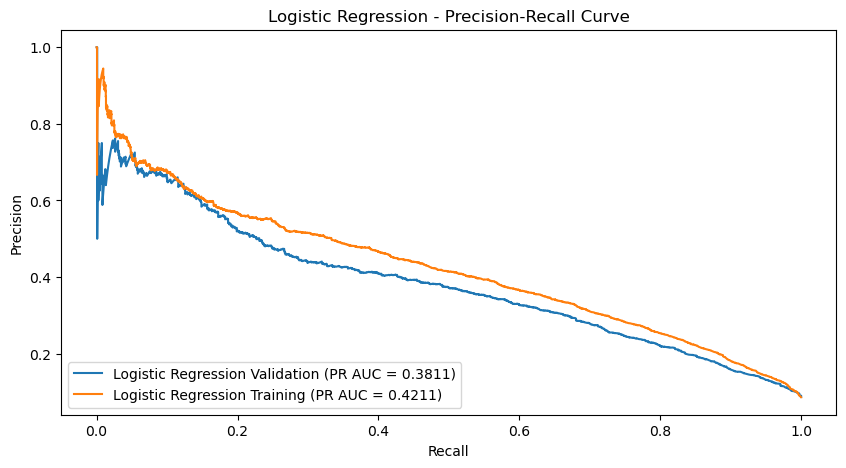


------------------------------------------------------------


Training Random Forest...
Validation Metrics for Random Forest:
Precision: 0.2699
Recall: 0.6902
F1-Score: 0.3881
ROC AUC: 0.8387
PR AUC: 0.3562


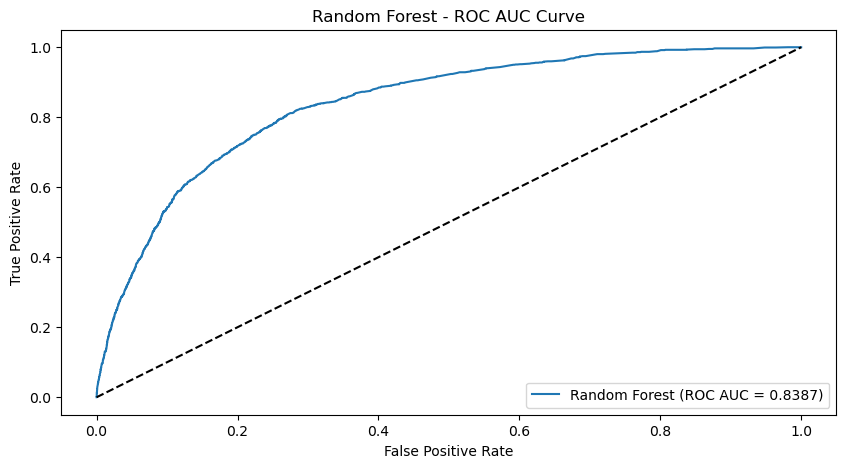

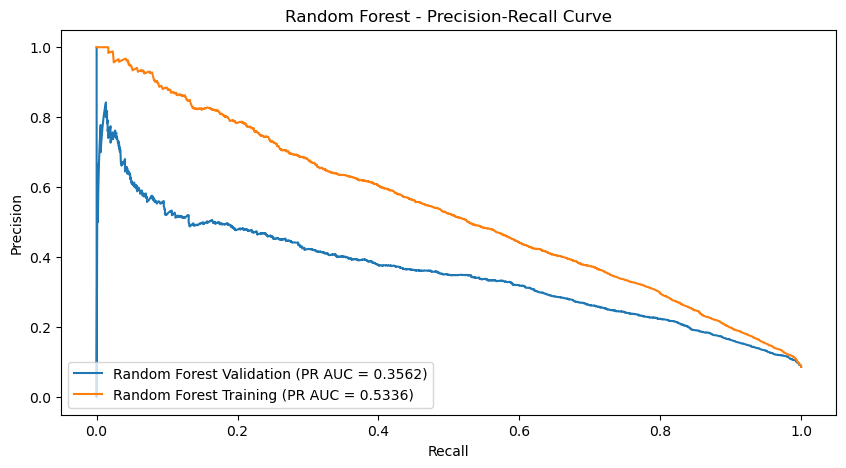


------------------------------------------------------------


Training Gradient Boosting...
Validation Metrics for Gradient Boosting:
Precision: 0.5477
Recall: 0.1652
F1-Score: 0.2538
ROC AUC: 0.8471
PR AUC: 0.3818


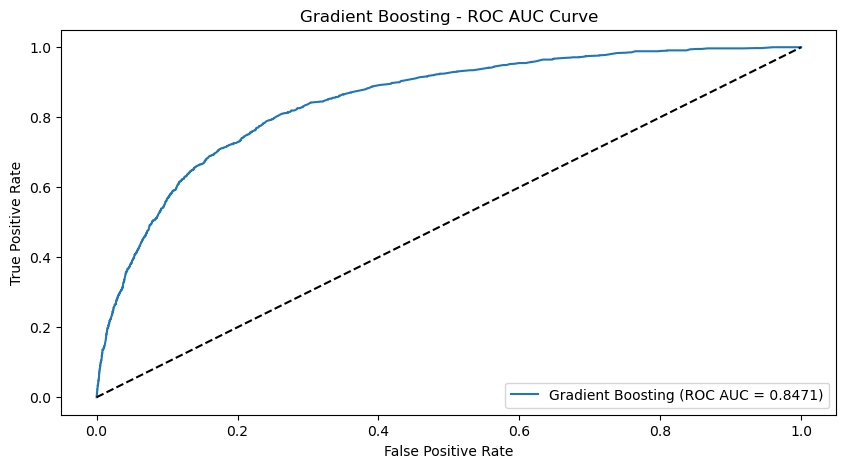

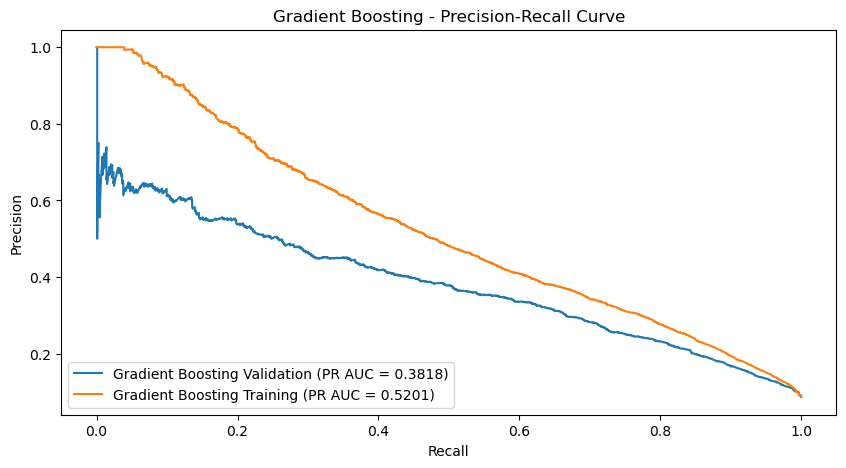


------------------------------------------------------------


Training XGBoost...


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/jinkettyee/

Validation Metrics for XGBoost:
Precision: 0.2636
Recall: 0.7329
F1-Score: 0.3877
ROC AUC: 0.8463
PR AUC: 0.3880


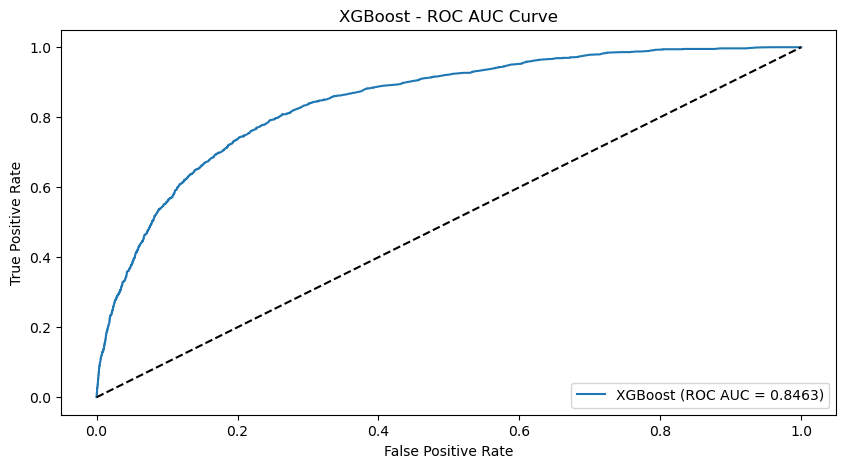

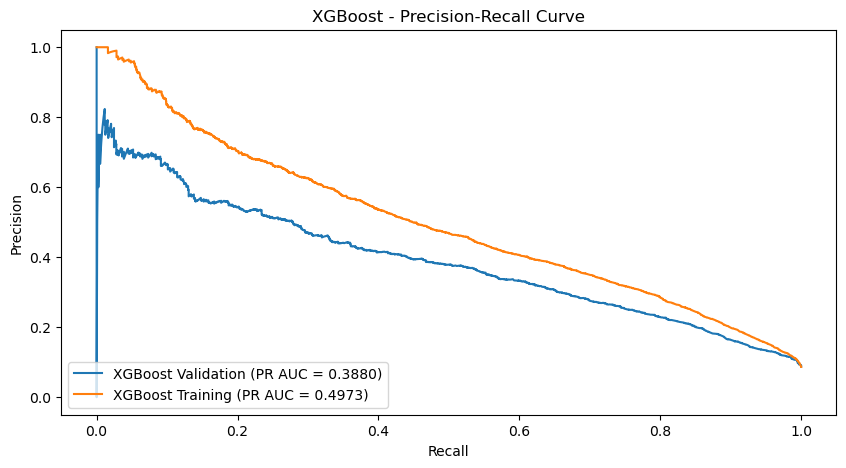


------------------------------------------------------------



In [8]:
def run_models(data, cat_cols, num_cols, target, threshold=0.5):
    # Split the data into train, validation, and test sets
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

    X_train = train_data[cat_cols + num_cols]
    y_train = train_data[target]
    X_val = val_data[cat_cols + num_cols]
    y_val = val_data[target]
    X_test = test_data[cat_cols + num_cols]
    y_test = test_data[target]

    # Preprocessing
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)])

    # Preprocess the training, validation, and test data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_test_preprocessed = preprocessor.transform(X_test)

    # Models with class_weight adjustments
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': XGBClassifier(random_state=42, scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), use_label_encoder=False, eval_metric='logloss')
    }

    # Hyperparameter grids for RandomizedSearchCV
    param_grids = {
        'Logistic Regression': {'C': np.logspace(-3, 3, 10)},
        'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
        'Gradient Boosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 7]},
        'XGBoost': {'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [3, 5, 7]}
    }

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")

        # Hyperparameter tuning
        search = RandomizedSearchCV(model, param_grids[model_name], n_iter=10, scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
        search.fit(X_train_preprocessed, y_train)

        best_model = search.best_estimator_

        # Predict probabilities
        y_val_pred_prob = best_model.predict_proba(X_val_preprocessed)[:, 1]
        y_test_pred_prob = best_model.predict_proba(X_test_preprocessed)[:, 1]

        # Apply threshold
        y_val_pred = (y_val_pred_prob >= threshold).astype(int)
        y_test_pred = (y_test_pred_prob >= threshold).astype(int)

        # Evaluate metrics
        print(f"Validation Metrics for {model_name}:")
        print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
        print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
        print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_val, y_val_pred_prob):.4f}")
        
        precision, recall, _ = precision_recall_curve(y_val, y_val_pred_prob)
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")

        # Plot ROC AUC curve
        fpr, tpr, _ = roc_curve(y_val, y_val_pred_prob)
        plt.figure(figsize=(10, 5))
        plt.plot(fpr, tpr, label=f'{model_name} (ROC AUC = {roc_auc_score(y_val, y_val_pred_prob):.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC AUC Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Plot Precision-Recall curve
        plt.figure(figsize=(10, 5))
        plt.plot(recall, precision, label=f'{model_name} Validation (PR AUC = {pr_auc:.4f})')
        train_precision, train_recall, _ = precision_recall_curve(y_train, best_model.predict_proba(X_train_preprocessed)[:, 1])
        train_pr_auc = auc(train_recall, train_precision)
        plt.plot(train_recall, train_precision, label=f'{model_name} Training (PR AUC = {train_pr_auc:.4f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name} - Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

        print("\n" + "-"*60 + "\n")

# Example usage:
run_models(data, cat_cols, num_cols, 'ICUMortalityrisk_ind', threshold=0.5)

### Neural Network Exploration

In [17]:
target = 'ICUMortalityrisk_ind'
test = cat_cols + num_cols + [target]
test

['GENDER',
 'Anemia category',
 'AnaestypeCategory',
 'PriorityCategory',
 'TransfusionIntraandpostopCategory',
 'AGEcategory',
 'SurgRiskCategory',
 'GradeofKidneyCategory',
 'RDW15.7',
 'ASAcategorybinned',
 'Preoptransfusionwithin30days',
 'Intraop',
 'Transfusionintraandpostop',
 'ICUMortalityrisk_ind']

In [5]:
# If you are using Apple M1, M2, M3 on your local machine
if not torch.cuda.is_available() and torch.backends.mps.is_available():
    if torch.backends.mps.is_built():
        device = "mpu"
        print('mpu is here!')

mpu is here!


/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Precision: 0.8295
Recall: 0.8034
F1-score: 0.8162
ROC AUC: 0.9008


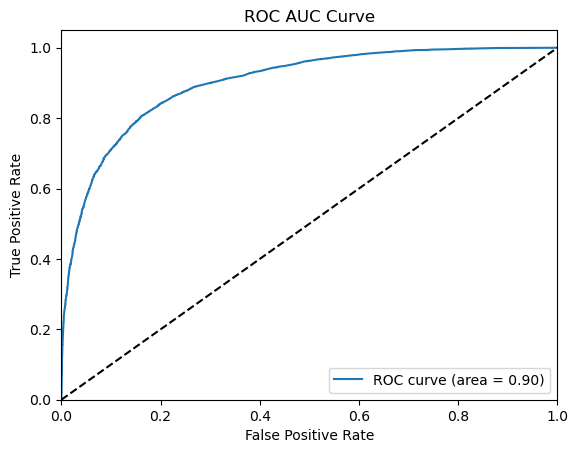

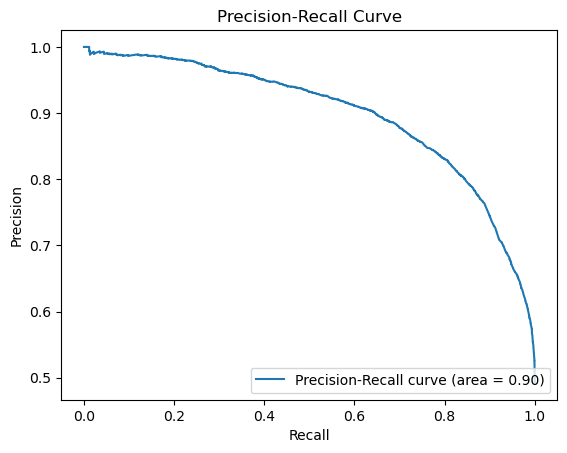

In [15]:
# Preprocessing function
def preprocess_data(data, cat_cols, num_cols, target):
    # One-hot encode categorical variables
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cat = encoder.fit_transform(data[cat_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols))
    
    # Standardize numerical variables
    scaler = StandardScaler()
    scaled_num = scaler.fit_transform(data[num_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols)
    
    # Combine encoded categorical and scaled numerical features
    X = pd.concat([encoded_cat_df, scaled_num_df], axis=1)
    y = data[target]
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    
    return X_res, y_res

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Function to train the model
def train_model(X_train, y_train, input_dim, epochs=20, batch_size=32, learning_rate=0.001):
    model = SimpleNN(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
        preds = (outputs >= 0.5).int()
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, outputs)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Plot ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, outputs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess the data
# Assuming 'data' is a pandas DataFrame
X_res, y_res = preprocess_data(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, input_dim)

# Evaluate the model
evaluate_model(model, X_test, y_test)

#### Without SMOTE Oversampling...

In [ ]:
# Preprocessing function
def preprocess_data(data, cat_cols, num_cols, target):
    # One-hot encode categorical variables
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_cat = encoder.fit_transform(data[cat_cols])
    encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(cat_cols))
    
    # Standardize numerical variables
    scaler = StandardScaler()
    scaled_num = scaler.fit_transform(data[num_cols])
    scaled_num_df = pd.DataFrame(scaled_num, columns=num_cols)
    
    # Combine encoded categorical and scaled numerical features
    X = pd.concat([encoded_cat_df, scaled_num_df], axis=1)
    y = data[target]
    
    return X, y

# Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Function to train the model
def train_model(X_train, y_train, input_dim, epochs=20, batch_size=32, learning_rate=0.001):
    model = SimpleNN(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
    
    return model

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.tensor(X_test.values, dtype=torch.float32)).squeeze()
        preds = (outputs >= 0.5).int()
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    roc_auc = roc_auc_score(y_test, outputs)
    
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    
    # Plot ROC AUC curve
    fpr, tpr, _ = roc_curve(y_test, outputs)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, outputs)
    pr_auc = auc(recall_curve, precision_curve)
    plt.figure()
    plt.plot(recall_curve, precision_curve, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower right")
    plt.show()

# Load and preprocess the data
# Assuming 'data' is a pandas DataFrame
X_res, y_res = preprocess_data(data, cat_cols, num_cols, 'ICUMortalityrisk_ind')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Train the model
input_dim = X_train.shape[1]
model = train_model(X_train, y_train, input_dim)

# Evaluate the model
evaluate_model(model, X_test, y_test)

/Users/jinkettyee/opt/anaconda3/envs/playground_py_3_9_15/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Concluding Statement
- Performed predictive modelling with Logistic Regression a suite of Tree-based Models (Random Forest, Gradient Boosting and XGBoost)
- Oversampling with SMOTE led to overfitting and inability of models to generalise well to test set - As seen in poor performance of Precision-Recall curves for validation/test set
- Balanced class-weights for models instead. Intuition: Assigning a higher weight to the minority class (positive cases) so that the model pays more attention to it during training. I.e. Models get penalised with greater loss if they misclassify minority class.
- Results & Discussion: Precision scores still remains low: High numbers of false positives (True negatives falsely predicted as positive cases). Recall and ROC AUC scores remain reasonably high. 
- Neural Network model performed the best (with SMOTE oversampling) with the following metric:
| Metric    | Value  |
|-----------|--------|
| Precision | 0.8295 |
| Recall    | 0.8034 |
| F1-score  | 0.8162 |
| ROC AUC   | 0.9008 |
